In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.svm import SVR, SVC
from utils import read_neutouch_raw, infer, bin_neutouch_signal

In [32]:
tool_length = 30
trial = 10
df_raw = read_neutouch_raw(f'/datasets/sensory_ext/data/neutouch/tool_neutouch_1k/trial{trial}_{tool_length}.tact')
# df_raw = df_raw.iloc[10000:250000]
df_essentials = pd.read_csv(f'/datasets/sensory_ext/data/neutouch/tool_neutouch_1k/trial{trial}_{tool_length}_essentials.csv')
#df_essentials = df_essentials.iloc[:9]
df_essentials = df_essentials[df_essentials.t <= df_raw.t.iloc[-1]]

In [33]:
tapped_times = df_essentials.t.values
len(tapped_times)

105

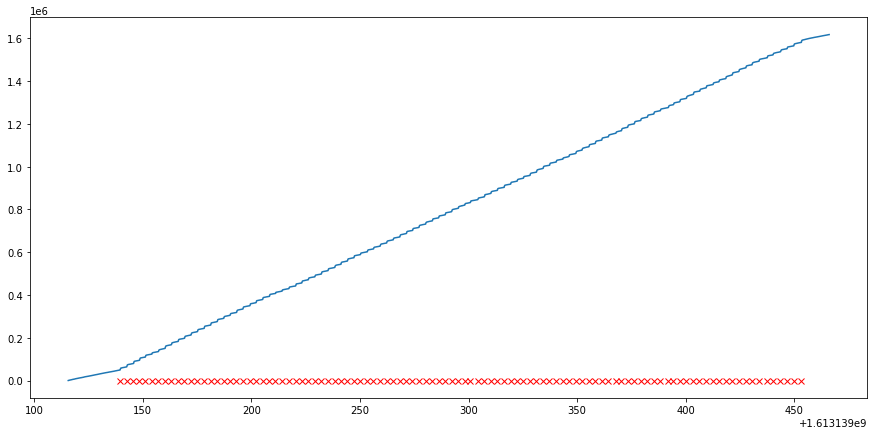

In [34]:
#df_raw.isPos[df_raw.isPos == 0] = -1
fig, ax =plt.subplots(figsize=(15,7))
ax.plot(df_raw.t.values, df_raw.isPos.cumsum().values)
ax.plot(df_essentials.t, np.zeros(df_essentials.t.shape), 'rx')
# ax.plot(where_happened, np.zeros(len(where_happened)), 'gx')
plt.show()

In [44]:
time_past = 0.05
time_future = 0.25
tap_time = tapped_times[0]
df_timespan = df_raw[(df_raw.t >= (tap_time - time_past)) & (df_raw.t < (tap_time + time_future))]

0      0.199787
1      0.080649
2      0.126195
3      0.152468
4      0.249933
         ...   
100    0.152694
101    0.053021
102    0.120800
103    0.229914
104    0.119607
Name: label_y, Length: 105, dtype: float64

In [118]:
def get_stats(tool_length, trial):

    df_raw = read_neutouch_raw(f'/datasets/sensory_ext/data/neutouch/tool_neutouch_1k/trial{trial}_{tool_length}.tact')
    df_essentials = pd.read_csv(f'/datasets/sensory_ext/data/neutouch/tool_neutouch_1k/trial{trial}_{tool_length}_essentials.csv')
    df_essentials = df_essentials[df_essentials.t <= df_raw.t.iloc[-1]]
    tapped_times = df_essentials.t.values
    interesting_taxels = [32, 22, 7, 17, 52, 42, 67, 77]
    result = np.zeros((1, len(interesting_taxels) + 1))
    
    for i, tap_time in enumerate(tapped_times):
        df_timespan = df_raw[(df_raw.t >= (tap_time - time_past)) & (df_raw.t < (tap_time + time_future))]
        spikes = [len(df_timespan[(df_timespan.taxel==interesting_taxel) & (df_timespan.isPos==0)]) for interesting_taxel in interesting_taxels]
        if df_essentials.label_y[i] < 0.02 or (df_essentials.label_y[i] > 0.08 and df_essentials.label_y[i] < 0.12) or (df_essentials.label_y[i] > 0.18 and df_essentials.label_y[i] < 0.22) or (df_essentials.label_y[i] > 0.28 and df_essentials.label_y[i] < 0.32) or (df_essentials.label_y[i] > 0.38 and df_essentials.label_y[i] < 0.42) or df_essentials.label_y[i] > 0.48:
            continue
        result = np.vstack((result, np.zeros((1, len(interesting_taxels) + 1))))
        result[-1, :-1] = np.array(spikes)
        result[-1, -1] = int(df_essentials.label_y[i] * 100) // 10

    stats = np.zeros((2, len(interesting_taxels) + 1))
    stats[0, :] = np.mean(result[result[:, -1] == 0], 0)
    stats[1, :] = np.mean(result[result[:, -1] == 1], 0)
#     stats[2, :] = np.mean(result[result[:, -1] == 2], 0)
#     stats[3, :] = np.mean(result[result[:, -1] == 3], 0)
#     stats[4, :] = np.mean(result[result[:, -1] == 4], 0)

    return stats

output = np.zeros((20, 9))
for trial in range(1, 11):
    output[2*(trial-1):2*trial] = get_stats(20, trial)

In [119]:
pd.DataFrame(output).to_csv('test20.xls')

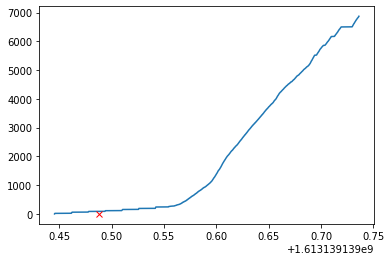

In [36]:
plt.plot(df_timespan.t, df_timespan.isPos.cumsum())
plt.plot(tap_time, 0, 'rx')

In [37]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    real_diff = np.abs(array[idx] - value)
    return array[idx], real_diff

In [38]:
raw_file = open(f'/datasets/sensory_ext/data/neutouch/tool_neutouch_1k/trial{trial}_{tool_length}.tact', 'r')
Lines = raw_file.readlines()

In [39]:
# do inference:
all_sample_dfs = []
df_timespans = []
my_ffts = []
def inference(t):
    sample_df = read_neutouch_raw("temp_signal.tact")
    signal, ss = bin_neutouch_signal(t, sample_df, 0.05, 0.25, 0.005)
    df_timespans.append(ss)
    res, my_fft = infer(signal, tool_length)
    #print('Predicted tap location:', res[0], t )
    #print(signal.shape)
    all_sample_dfs.append(sample_df)
    my_ffts.append(my_fft)
    return res[0]
    
def inference2(t):
    df_timespan = df_raw[(df_raw.t >= (t - time_past)) & (df_raw.t < (t + time_future))]
    signal, ss = bin_neutouch_signal(t, df_timespan, 0.05, 0.25, 0.005)
    res, my_fft = infer(signal, tool_length)
    return res[0]

In [40]:
DIFF_THRESHOLD = -50
window_size = 1000
waiting_time = 2

In [31]:
window = []
temp_f = open("temp_signal.tact", "w")
info = []
last_detection = 0.0
update_time = 0.0
where_happened = []
all_count = 0

recorded_time =[]
for i, line in enumerate(Lines):
    isPos, index, _, t = line.split(' ')
    
#     if i < 10000:
#         continue
#     if i >= 270000:
#         break
    
    isPos = int(isPos)
    index = int(index)
    t = float(t)
    
    if not temp_f.closed:
        temp_f.write(str(isPos)+' '+str(index) + ' 1 ' +str(t)+'\n')
    
    if (t-last_detection) < waiting_time:
        
        if update_time <= t:
            # need to infer here
            # publish here
            if not temp_f.closed:
                temp_f.close()
                #print('found at', all_count,'closed at t', t, 'prediction: ')
                print('My prediction is:', inference(last_detection) )
                
                real_time, delta = find_nearest(  df_essentials.t.values, last_detection )
                if delta < 1.0:
                    print(delta)
                    print('Real prediction is:', inference2(df_essentials[df_essentials.t == real_time].t.values[0]) )
                
                all_count+=1
        continue
        

    if last_detection < t - waiting_time:
        if temp_f.closed:
            temp_f = open("temp_signal.tact", "w")
    # detection_procedure
    
    if len(window) < window_size:
        window.append(isPos)
    else:
        window.pop(0)
        window.append(isPos)
        
    pos = len( [x for x in window if x == 1] )
    neg = len( [x for x in window if x == 0] )
    
    recorded_time.append(t)
    info.append((pos,neg))
    
    if (pos-neg) < DIFF_THRESHOLD:
        where_happened.append(t-0.03)
        print('----------------- detected:')
        last_detection = t-0.03
        update_time = t+0.3
        window = []
    
    #print(pos, neg)

----------------- detected:
My prediction is: 29.708927987253865
0.046677350997924805
Real prediction is: 30.978733444629125
----------------- detected:
My prediction is: 25.89692906805918
0.04213237762451172
Real prediction is: 29.21997298105825
----------------- detected:
My prediction is: 26.500206504564275
0.04733705520629883
Real prediction is: 30.750179330891342
----------------- detected:
My prediction is: 27.162792735945587
0.045589447021484375
Real prediction is: 34.44770095317617
----------------- detected:
My prediction is: 30.04735420344234
0.04939603805541992
Real prediction is: 32.28893552727485
----------------- detected:
My prediction is: 27.432824787312843
0.04098081588745117
Real prediction is: 28.933594809200134
----------------- detected:
My prediction is: 19.123074950224883
0.028674840927124023
Real prediction is: 18.91555513679033
----------------- detected:
My prediction is: 30.063305633124358
0.024762630462646484
Real prediction is: 33.91407725895813
-----------

----------------- detected:
My prediction is: 30.25943358880575
0.1351025104522705
Real prediction is: 38.91393370062028
----------------- detected:
My prediction is: 25.557182886771976
0.032334089279174805
Real prediction is: 27.167079577875747
----------------- detected:


KeyboardInterrupt: 

In [18]:
recorded_time[-1] - where_happened[-1]

20.43871808052063

In [19]:
info

[(1, 0),
 (2, 0),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (24, 2),
 (24, 3),
 (24, 4),
 (25, 4),
 (26, 4),
 (27, 4),
 (28, 4),
 (29, 4),
 (30, 4),
 (31, 4),
 (32, 4),
 (33, 4),
 (34, 4),
 (35, 4),
 (36, 4),
 (37, 4),
 (38, 4),
 (39, 4),
 (39, 5),
 (40, 5),
 (41, 5),
 (42, 5),
 (43, 5),
 (43, 6),
 (43, 7),
 (43, 8),
 (43, 9),
 (44, 9),
 (45, 9),
 (46, 9),
 (47, 9),
 (48, 9),
 (49, 9),
 (50, 9),
 (51, 9),
 (52, 9),
 (53, 9),
 (54, 9),
 (55, 9),
 (56, 9),
 (57, 9),
 (58, 9),
 (59, 9),
 (60, 9),
 (61, 9),
 (62, 9),
 (63, 9),
 (64, 9),
 (65, 9),
 (66, 9),
 (67, 9),
 (68, 9),
 (69, 9),
 (70, 9),
 (71, 9),
 (72, 9),
 (73, 9),
 (74, 9),
 (75, 9),
 (76, 9),
 (77, 9),
 (78, 9),
 (79, 9),
 (80, 9),
 (81, 9),
 (82, 9),
 (83, 9),
 (84, 9),
 (85, 9),
 (86, 9),
 (87, 9),
 (88, 9),
 (89, 9),
 (90, 9),
 (91, 9),
 (92, 9),


In [13]:
len(where_happened)

100

In [14]:
df_essentials

,original_index,t,label_y
0,508,1.613134e+09,0.299262
1,601,1.613134e+09,0.179085
2,687,1.613134e+09,0.309180
3,777,1.613134e+09,0.185982
4,863,1.613134e+09,0.343800
...,...,...,...
95,8993,1.613135e+09,0.165898
96,9082,1.613135e+09,0.092677
97,9172,1.613135e+09,0.193262
98,9260,1.613135e+09,0.256070


In [15]:
info = np.array(info)
a  = info[:,0]-info[:,1]

In [16]:
a.shape

(376145,)

(-100.0, 20.0)

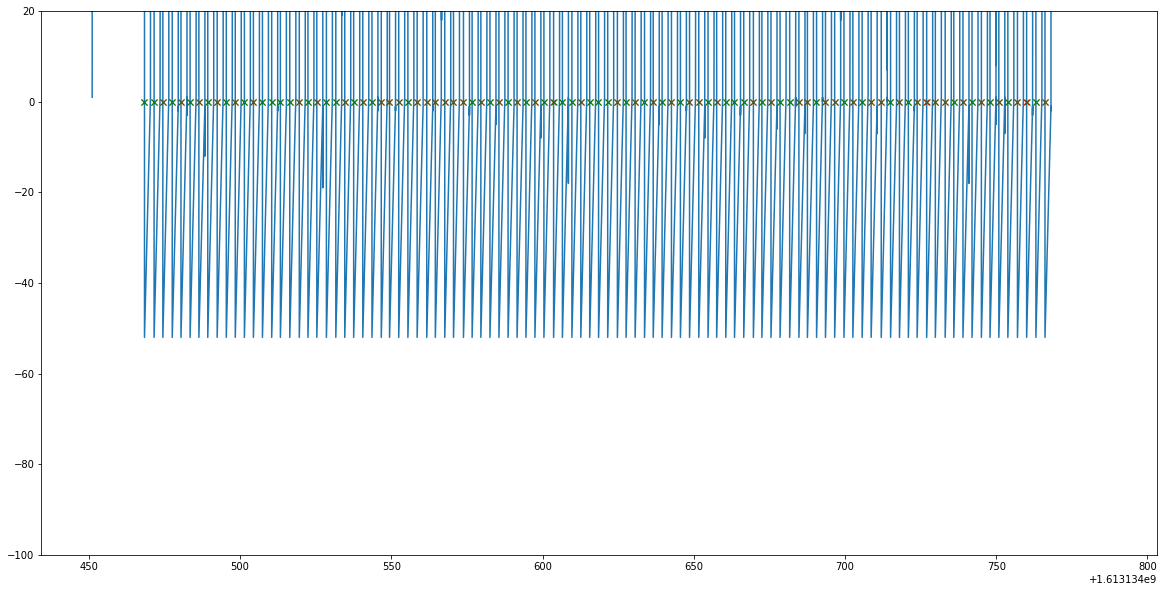

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(recorded_time,  a)
ax.plot(df_essentials.t, np.zeros(len(df_essentials.t)), 'rx')
ax.plot(where_happened, np.zeros(len(where_happened)), 'gx')
ax.set_ylim([-100,20])

In [18]:
df_essentials.t.values - np.array(where_happened)

array([-1.50232315e-02, -2.98941135e-02,  7.41648674e-03, -3.96029949e-02,
       -4.93836403e-03, -2.76691914e-02, -1.94406509e-03, -1.69324875e-02,
        2.99098730e+00,  2.94066596e+00,  2.99690366e+00,  2.94086289e+00,
        2.98486042e+00,  3.02299476e+00,  2.85595202e+00,  3.08096266e+00,
        3.14610124e+00,  2.85144114e+00,  2.91176677e+00,  3.14610314e+00,
        3.06742835e+00,  2.92001987e+00,  2.95278621e+00,  3.00021625e+00,
        3.01206326e+00,  3.00674987e+00,  2.71915174e+00,  3.00768566e+00,
        3.00225377e+00,  3.02872372e+00,  3.13181877e+00,  2.84249473e+00,
        3.10673213e+00,  2.87700772e+00,  3.28605437e+00,  2.84258270e+00,
        2.87465930e+00,  2.98052573e+00,  2.93795943e+00,  2.96154308e+00,
        2.96209598e+00,  2.91267014e+00,  2.93934822e+00,  2.96704555e+00,
        3.18622231e+00,  2.87162566e+00,  3.12296772e+00,  2.90995193e+00,
        2.95045137e+00,  2.93221116e+00,  2.99719596e+00,  3.17894936e+00,
        2.83140779e+00,  

In [19]:
df_essentials.t.values[3]

1613134477.5083294

In [20]:
where_happened

[1613134468.3746216,
 1613134471.5513077,
 1613134474.441963,
 1613134477.5479324,
 1613134480.4372427,
 1613134483.4540017,
 1613134486.3552947,
 1613134489.2941265,
 1613134492.4071493,
 1613134495.41639,
 1613134498.3861184,
 1613134501.402114,
 1613134504.3841035,
 1613134507.3719,
 1613134510.4288974,
 1613134513.301821,
 1613134516.4006882,
 1613134519.5513093,
 1613134522.4150293,
 1613134525.3425167,
 1613134528.516154,
 1613134531.622888,
 1613134534.5837426,
 1613134537.5292764,
 1613134540.5443628,
 1613134543.576629,
 1613134546.6522217,
 1613134549.3886075,
 1613134552.4211323,
 1613134555.4555275,
 1613134558.515399,
 1613134561.6946518,
 1613134564.524481,
 1613134567.6430593,
 1613134570.5339694,
 1613134573.8314102,
 1613134576.6892712,
 1613134579.5773566,
 1613134582.5838888,
 1613134585.5522416,
 1613134588.5776603,
 1613134591.5510402,
 1613134594.4823673,
 1613134597.4465857,
 1613134600.4254017,
 1613134603.6289818,
 1613134606.5385826,
 1613134609.6756504,
 1613

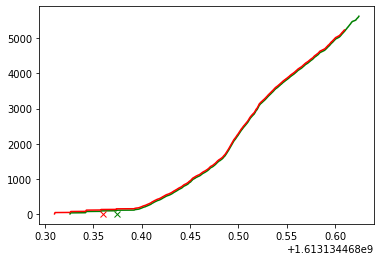

In [21]:
sample_id = 0
plt.plot(df_timespans[sample_id].t, df_timespans[sample_id].isPos.cumsum(), 'g-')
plt.plot(where_happened[sample_id], 1, 'gx')


tap_time = tapped_times[sample_id]
df_timespan = df_raw[(df_raw.t >= (tap_time - time_past)) & (df_raw.t < (tap_time + time_future))]

plt.plot(df_timespan.t, df_timespan.isPos.cumsum(), 'r-')
plt.plot(tap_time, 1, 'rx')

In [22]:
all_sample_dfs[0].t[0]

1613134451.1127193

In [23]:
df_timespan.t.iloc[0]

1613134468.309857

In [24]:
time_future

0.25

In [25]:
tap_time = tapped_times[3]
#df_timespan = df_raw[(df_raw.t >= (tap_time - time_past)) & (df_raw.t < (tap_time + time_future))]
#print(df_timespan.shape)
infer( bin_neutouch_signal(tap_time, df_raw, 0.05, 0.25,0.005)[0] )

(array([18.49789489]),
 array([[0.007     , 0.0196778 , 0.0178301 , ..., 0.00747226, 0.00865035,
         0.00775392]]))

In [26]:
df_essentials

,original_index,t,label_y
0,508,1.613134e+09,0.299262
1,601,1.613134e+09,0.179085
2,687,1.613134e+09,0.309180
3,777,1.613134e+09,0.185982
4,863,1.613134e+09,0.343800
...,...,...,...
95,8993,1.613135e+09,0.165898
96,9082,1.613135e+09,0.092677
97,9172,1.613135e+09,0.193262
98,9260,1.613135e+09,0.256070


In [27]:
tapped_times = df_essentials.t.values

all_values = []
old_ffts = []
for i, row in df_essentials.iterrows():
    t, label  = row.t, row.label_y
    y_pred, old_fft = infer( bin_neutouch_signal(t, df_raw, 0.05, 0.25, 0.005)[0], tool_length)
    all_values.append([label, y_pred])
    old_ffts.append(old_fft)

In [28]:
all_values

[[0.2992622595647691, array([24.65965098])],
 [0.1790845658997414, array([18.00854531])],
 [0.3091802601138471, array([31.01804418])],
 [0.185982194207084, array([18.49789489])],
 [0.3438003309438346, array([34.48035224])],
 [0.1463564899186013, array([14.53527383])],
 [0.3762535475561736, array([37.50541682])],
 [0.135614436529052, array([13.66106656])],
 [0.1804076698044656, array([23.00818287])],
 [0.1192383434990762, array([11.82353746])],
 [0.1781218167761681, array([21.00112879])],
 [0.2601851713279603, array([25.16764159])],
 [0.3686832188995896, array([34.69061679])],
 [0.114759933612716, array([11.57612822])],
 [0.1950698312739251, array([19.60696469])],
 [0.2596522163967011, array([26.06564242])],
 [0.3430731486896394, array([34.81150707])],
 [0.1164967384556649, array([11.74994321])],
 [0.219868313930404, array([23.75964639])],
 [0.1066497680167077, array([10.76531822])],
 [0.1266081300000069, array([12.76109096])],
 [0.1938781854132531, array([21.25976945])],
 [0.2914991420

In [29]:
from sklearn.metrics import euclidean_distances

In [30]:
euclidean_distances( old_ffts[0], old_ffts[1])

array([[0.10143196]])

In [31]:
euclidean_distances( old_ffts[0], my_ffts[0])

array([[0.04768289]])